### Alvins yrken för personer kopplade till Wikidata

De personer > 27000 som kopplats till Wikidata söks igenom och yrjet hämtas från Alvin via webscrabing 
* Wikidata [P6821](https://www.wikidata.org/wiki/Property_talk:P6821)
* [T225522](https://phabricator.wikimedia.org/T225522) "Property Alvin P6821 created and need to be matched"

* GITHUB [salgo60/HISCOKoder](https://github.com/salgo60/HISCOKoder)
  * this [Notebook](https://github.com/salgo60/HISCOKoder/blob/main/Jupyter/Alvin%20yrken%20version%202.ipynb)

In [1]:
from datetime import datetime
start_time  = datetime.now()
print("Last run: ", start_time)

Last run:  2021-08-15 20:29:05.426637


In [2]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys,json
import pandas as pd 

from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

queryAlvin = """SELECT ?item ?itemLabel ?alvinid WHERE {
  ?item wdt:P6821 ?alvinid.
  ?item wdt:P31 wd:Q5.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "sv". }
} limit 30000"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDAlvintot = get_sparql_dataframe(endpoint_url, queryAlvin)
WDAlvintot["Source"] = "Alvin"

In [3]:
WDAlvintot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28370 entries, 0 to 28369
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   item       28370 non-null  object
 1   itemLabel  28370 non-null  object
 2   alvinid    28370 non-null  object
 3   Source     28370 non-null  object
dtypes: object(4)
memory usage: 886.7+ KB


In [4]:
WDAlvintot.head(5)

,item,itemLabel,alvinid,Source
0,http://www.wikidata.org/entity/Q297,Diego Velázquez,alvin-person:61604,Alvin
1,http://www.wikidata.org/entity/Q619,Nicolaus Copernicus,alvin-person:12091,Alvin
2,http://www.wikidata.org/entity/Q747,Pierre Corneille,alvin-person:67256,Alvin
3,http://www.wikidata.org/entity/Q859,Platon,alvin-person:29707,Alvin
4,http://www.wikidata.org/entity/Q859,Platon,alvin-person:69659,Alvin


In [5]:
import requests
import urllib.request
import time
from bs4 import BeautifulSoup, NavigableString, Tag
from tqdm.notebook import tqdm  

newList = []
urlBase = "https://www.alvin-portal.org/alvin/view.jsf?pid="
for index, row in tqdm(WDAlvintot.iterrows(), total=WDAlvintot.shape[0]):    
    #time.sleep(5)
    alvinid = row['alvinid']
    person = row['itemLabel']
    url = urlBase + alvinid
    #print(url)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    for header in soup.find_all('h2'): 
        nextNode = header
        if "Occupation" in header:
            while True:
            
                nextNode = nextNode.nextSibling
                if nextNode is None:
                    break
                if isinstance(nextNode, NavigableString):
#                    print (alvinid,"-",person,"\tyrke: ",nextNode.strip())
#alvin-person:1063 - Marie Curie 	yrke:  Fysiker, Radiolog, Kemist, Chemist, Physicist, kemist, fysiker
#alvin-person:48342 - Simone de Beauvoir 	yrke:  författare, filosof, feminist
#alvin-person:27012 - Ingmar Bergman 	yrke:  Regissör, Författare, regissör
#alvin-person:64330 - Grazia Deledda 	yrke:  Författarinna
#
#
                    newList.append(nextNode.strip())
                    break

print("Lines found:\t", len(newList))    
# TBD
    

  0%|          | 0/28370 [00:00<?, ?it/s]

Lines found:	 21091


In [6]:
import pandas as pd
newListdf = pd.DataFrame(newList,columns=list(["Yrke"]))

In [7]:
newListdf

,Yrke
0,Konstnär
1,Astronomer
2,"Advokat, Kompositör, Författare, Tonsättare"
3,filosof
4,Förenta nationernas generalsekreterare
...,...
21086,"författare, fil. dr."
21087,"Språkforskare, Professor"
21088,"politiker, jägmästare"
21089,"Historiker, Professor"


In [8]:
yrkendf = pd.concat([pd.Series(row['Yrke'].split(','))              
                    for _, row in newListdf.iterrows()]).reset_index() 
yrkendf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36774 entries, 0 to 36773
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   36774 non-null  int64 
 1   0       36774 non-null  object
dtypes: int64(1), object(1)
memory usage: 574.7+ KB


In [9]:
mapping = {yrkendf.columns[1]:'yrke'}
yrkendf = yrkendf.rename(columns=mapping)
yrkendf["yrke"] = yrkendf['yrke'].str.strip()
yrkenAlvin = yrkendf["yrke"].value_counts() 

Text(0.5, 1.0, 'Vanligaste Yrken i Alvin kopplade till person i Wikidata')

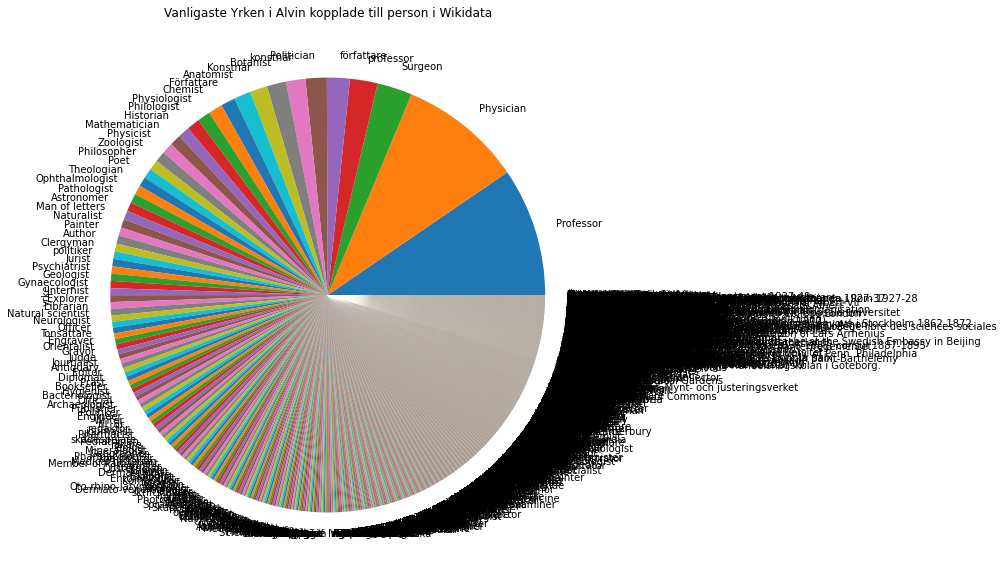

In [18]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
ax = yrkenAlvin.plot(kind='pie')

ax.set_title("Vanligaste Yrken i Alvin kopplade till person i Wikidata")

In [19]:
#fig = pie[0].get_figure()
fig = ax.get_figure()
plt.rcParams['savefig.facecolor']='white'
fig.savefig("Alvin_yrken_alla.png")

In [20]:
yrkenAlvin.to_csv("Alvin_yrken_value_counts.csv")

In [21]:
end_time  = datetime.now()
print("Last run: ", end_time)

Last run:  2021-08-15 23:39:40.533543
